In [1]:
# See https://github.com/tensorflow/tensorflow/issues/31249
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
tf.disable_eager_execution()

In [3]:
batch_size=512
x2_dist=tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(batch_size)
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                scale=tf.ones(batch_size, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

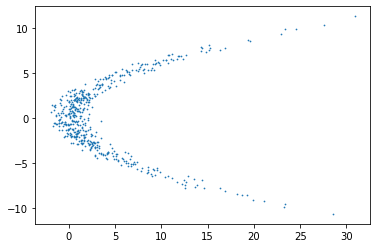

In [7]:
plt.scatter(x_samples[:,0], x_samples[:,1], s=.5)

In [4]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))

In [5]:
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=.5, validate_args=True, name="leaky_relu"):
        super().__init__(inverse_min_event_ndims=1, validate_args=validate_args, name=name)
        self.alpha = alpha
    
    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)
    
    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1./ self.alpha*y)
    
    def _inverse_log_det_jacobian(self, y):
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1/self.alpha * I)
        log_abs_det_j_inv = tf.log(tf.abs(J_inv))
        return tf.reduce_sum(log_abs_det_j_inv, axis=1)

In [6]:
d, r = 2, 2
DTYPE = tf.float32
bijectors = []
num_layers = 6
for i in range(num_layers):
    print('bijector_{}'.format(i))
    with tf.variable_scope('bijector_{}'.format(i)):
        V = tf.get_variable('V', [d, r], dtype=DTYPE)
        shift = tf.get_variable('shift', [d], dtype=DTYPE)
        L = tf.get_variable('L', [d * (d+1)/2], dtype=DTYPE)
        bijectors.append(tfb.Affine(
            scale_tril=tfd.fill_triangular(L),
            scale_perturb_factor=V,
            shift=shift,))
        alpha = tf.abs(tf.get_variable('alpha', [], dtype=DTYPE)) + .01
        bijectors.append(LeakyReLU(alpha=alpha))

bijector_0
alpha:  Tensor("bijector_0/add:0", shape=(), dtype=float32)
bijector_1
alpha:  Tensor("bijector_1/add:0", shape=(), dtype=float32)
bijector_2
alpha:  Tensor("bijector_2/add:0", shape=(), dtype=float32)
bijector_3
alpha:  Tensor("bijector_3/add:0", shape=(), dtype=float32)
bijector_4
alpha:  Tensor("bijector_4/add:0", shape=(), dtype=float32)
bijector_5
alpha:  Tensor("bijector_5/add:0", shape=(), dtype=float32)


In [7]:
mlp_bijector = tfb.Chain(
    list(reversed(bijectors[:-1])), name='2d_mlp_bijector')
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=mlp_bijector
)

In [8]:
loss = -tf.reduce_mean(dist.log_prob(x_samples))

W0808 08:51:53.549797 140478491137856 deprecation.py:323] From <ipython-input-5-2e00977d122a>:10: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [18]:
sess = tf.InteractiveSession()

In [19]:
sess.run(tf.global_variables_initializer())

In [35]:
NUM_STEPS = 5_000
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    np_loss, _ = sess.run([loss, train_op])
    if i % 100 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % 100 == 0:
        print(i, np_loss)

0 5.744356
100 6.091959
200 5.928139
300 5.4733906
400 5.6101484
500 5.69313
600 5.4639854
700 5.5899067
800 5.583472
900 5.5599985
1000 5.6575747
1100 5.49792
1200 5.4922113
1300 5.4435344
1400 5.7452397
1500 5.370224
1600 5.7687283
1700 5.352703
1800 5.8170066
1900 5.323447
2000 5.421354
2100 5.3098574
2200 5.3724813
2300 5.1410046
2400 5.41873
2500 5.282753
2600 5.173178
2700 5.1954584
2800 5.2876544
2900 5.086817
3000 5.2024035
3100 5.0978823
3200 5.6847715
3300 4.9323015
3400 4.9715557
3500 5.1184263
3600 4.847639
3700 4.8994837
3800 4.7866344
3900 4.8263655
4000 4.814864
4100 4.8328238
4200 4.8588133
4300 4.699997
4400 4.8988442
4500 4.711617
4600 4.763747
4700 4.7839518
4800 4.7598624
4900 4.796231


In [36]:
res = sess.run(dist.sample(512))

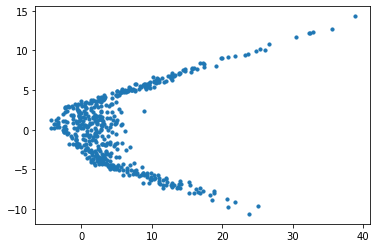

In [37]:
plt.scatter(res[:,0], res[:,1], s=10)

In [38]:
# visualization
x = base_dist.sample(512)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

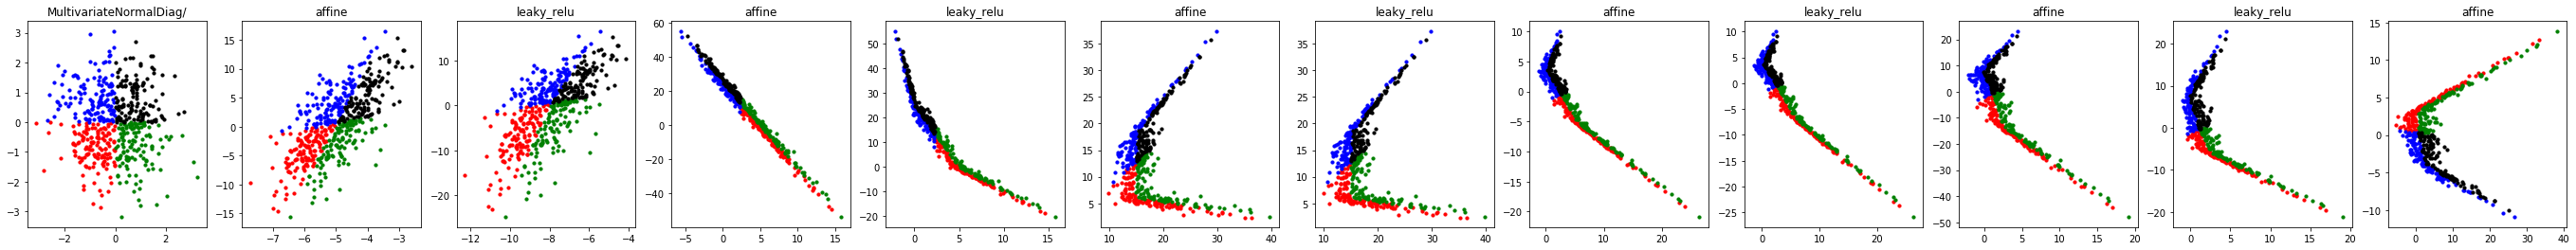

In [39]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
#     arr[i].set_xlim([-2, 2])
#     arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])